In [29]:
local_path = './'

"""## Prepare fastai"""
from fastai import *
from fastai.text import *
from fastai.metrics import *
from fastai.callbacks.tensorboard import LearnerTensorboardWriter
from fastai.callbacks.misc import StopAfterNBatches
import datetime
from pytz import timezone

torch.cuda.set_device(1)
np.random.seed(0)
"""## Prepare Dataset"""
local_project_path = local_path + 'data/cafa3/'
if not os.path.exists(local_project_path):
    os.makedirs(local_project_path)
print('local_project_path:', local_project_path)

"""## Create Language Model"""
class dna_tokenizer(BaseTokenizer):
    def tokenizer(self, t):
        res = []
        tokens = t.split(' ')
        if len(tokens) == 3:
            bos = tokens[0]
            text = tokens[1]
            eos = tokens[2]
            res = list(text)
            res.insert(0, bos)
            res.append(eos)
        else:
            res = list(tokens)
        return res
tokenizer = Tokenizer(tok_func=dna_tokenizer, pre_rules=[], post_rules=[], special_cases=[])
processor = [TokenizeProcessor(tokenizer=tokenizer, include_bos= True, include_eos=True), NumericalizeProcessor(max_vocab=30000)]

local_project_path: ./data/cafa3/


In [64]:
# batch size
bs = 8
data_lm = TextLMDataBunch.from_csv('bp_deepred/', 'combined.csv',
                                   text_cols ='seq', valid_pct= 0.1, tokenizer=tokenizer,
                                   include_bos= True, include_eos=True, bs=bs)
print('data_cls Training set size', len(data_lm.train_ds))
print('data_cls Validation set size', len(data_lm.valid_ds))

data_cls Training set size 129303
data_cls Validation set size 14368


In [91]:
data_cls = (TextList.from_csv(local_project_path, 'uniprot_sprot_exp_go_all.csv', cols='seq', vocab=data_lm.vocab, processor=processor)
                    .split_by_rand_pct(0.10)
                   .label_from_df(cols='labels', label_delim=' ')
                   .databunch(bs=bs))

In [93]:
print(len(data_cls.train_ds))
print(len(data_cls.valid_ds))

60157
6684


In [66]:
data_cls.train_ds.y[10400]

MultiCategory GO:0071949;GO:0016627

In [67]:
# # batch size
# bs = 256
# data_cls = TextClasDataBunch.from_csv(local_project_path, 'uniprot_sprot_exp_go_F.csv',
#                                    text_cols ='seq', valid_pct= 0.1, tokenizer=tokenizer,
#                                    include_bos= True, include_eos=True, classes='labels', bs=bs)
# print('data_cls Training set size', len(data_lm.train_ds))
# print('data_cls Validation set size', len(data_lm.valid_ds)) 

In [68]:
data_cls.show_batch()

text,target
xxbos M T T Q A P M F T Q P L Q S V V V L E G S T A T F E A H V S G S P V P E V S W F R D G Q V I S T S T L P G V Q I S F S D G R A R L M I P A,GO:0005200;GO:0030506
xxbos M S S D S R K T F V V T T I A C A I A P A G Q Q D Q Y A A Y L G Q D E N G A I A S F L D S T Q N T L Q A G V S G L G T G Q L Q L K L S N A,GO:0003774;GO:0045503
xxbos M L W W E E V E D C Y E R E D V Q K K T F T K W I N A Q F S K F G K Q H I D N L F S D L Q D G K R L L D L L E G L T G Q K L P K E K G S T,GO:0050998
xxbos M D P R N T A M L G L G S D S E G F S R K S P S A I S T G T L V S K R E V E L E K N T K E E E D L R K R N R E R N I E A G K D D G L T D A,GO:0046975
xxbos M N P I H D R T S D Y H K Y L K V K Q G D S D L F K L T V S D K R Y I W Y N P D P K E R D S Y E C G E I V S E T S D S F T F K T V D G Q D,GO:0000146;GO:0003774;GO:0005524;GO:0030554;GO:0030898;GO:0042803;GO:0051015;GO:0071889


In [69]:
len(data_lm.vocab.itos)

40

In [131]:
acc_02 = partial(accuracy_thresh, thresh=0.5)
f_score = partial(fbeta, thresh=0.5, beta=1)

In [140]:
learn_cls = text_classifier_learner(data_cls, AWD_LSTM, drop_mult=0.05, pretrained=False, metrics =[acc_02, f_score]).to_fp16()

In [132]:
learn_cls.metrics =[acc_02, f_score]

In [98]:
learn_cls.load_encoder('../../../bp_deepred/models/lm2-v2-21_enc');

In [11]:
learn_lm.data.batch_size = 256

In [87]:
def add_tensorboard_callback(learn_lm):
    now = datetime.datetime.now().astimezone(timezone('US/Eastern'))
    time_for_different_run = f'{now.year}-{now.month}-{now.day}-{now.hour}-{now.minute}-{now.second}'

    proj_id = 'cafa' + time_for_different_run
    tboard_path = Path('log/' + proj_id)
    remove_tensorboard_callback(learn_lm)
    learn_lm.callback_fns.append(partial(LearnerTensorboardWriter, base_dir=tboard_path, name='CafaLearner'))

def remove_tensorboard_callback(learn_lm):
    if len(learn_lm.callback_fns) > 1: # not the best way to check this !!
        learn_lm.callback_fns.pop()


In [88]:
add_tensorboard_callback(learn_cls)

In [ ]:
remove_tensorboard_callback(learn_cls)
learn_cls.lr_find()
add_tensorboard_callback(learn_cls)

Min numerical gradient: 1.00E-05
Min loss divided by 10: 3.63E-06


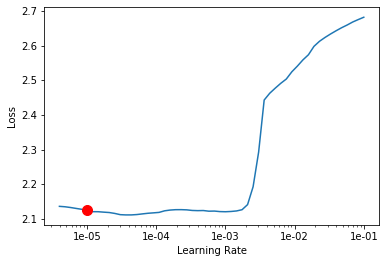

In [24]:
learn_cls.recorder.plot(skip_start=20, skip_end=20, suggestion = True)

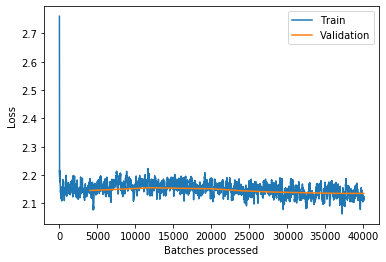

In [21]:
learn_lm.recorder.plot_losses()

In [ ]:
learn_lm.recorder.plot_lr(show_moms=True)

In [ ]:
learn_lm.recorder.plot_metrics()

In [133]:
learn_cls.fit_one_cycle(1, slice(1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.001742,0.064388,0.998498,0.006262,25:53


In [134]:
learn_cls.fit_one_cycle(10, slice(1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.001625,0.079187,0.998023,0.009093,23:57
1,0.001616,0.054734,0.997867,0.009642,27:48
2,0.001844,0.006360,0.999383,0.008230,27:44


KeyboardInterrupt: 

In [138]:
learn_cls.unfreeze()

In [144]:
learn_cls.fit_one_cycle(10, slice(1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,top_k_accuracy,time


RuntimeError: expand(torch.cuda.FloatTensor{[8, 23641, 1]}, size=[8, 5]): the number of sizes provided (2) must be greater or equal to the number of dimensions in the tensor (3)

In [ ]:
learn_cls.fit_one_cycle(10, slice(1e-4), moms=(0.8,0.7))

In [ ]:
learn_cls.fit_one_cycle(10, slice(1e-4), moms=(0.8,0.7))

In [47]:
learn_lm.unfreeze()

In [143]:
learn_cls.validate(metrics=[partial(accuracy_thresh, thresh=0.5), partial(fbeta, thresh=0.5, beta = 1), top_k_accuracy])

RuntimeError: expand(torch.cuda.FloatTensor{[8, 23641, 1]}, size=[8, 5]): the number of sizes provided (2) must be greater or equal to the number of dimensions in the tensor (3)

In [102]:
pred = learn_cls.get_preds()

[tensor([[2.7297e-05, 2.7260e-04, 5.7191e-04,  ..., 2.7800e-05, 2.9218e-05,
          2.6499e-05],
         [1.7810e-05, 5.4410e-05, 4.4754e-04,  ..., 1.9299e-05, 1.7779e-05,
          1.9321e-05],
         [2.6262e-05, 3.5846e-04, 4.9825e-04,  ..., 2.5443e-05, 2.8924e-05,
          1.9955e-05],
         ...,
         [1.0798e-05, 2.6381e-04, 3.3900e-04,  ..., 9.1010e-06, 9.6668e-06,
          8.7560e-06],
         [8.1520e-06, 2.5076e-04, 3.0428e-04,  ..., 6.5817e-06, 7.3495e-06,
          7.1095e-06],
         [8.0461e-06, 2.4322e-04, 3.0105e-04,  ..., 6.5205e-06, 7.1319e-06,
          7.0125e-06]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]])]

In [136]:
learn_cls.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [5, 400]             0          False     
______________________________________________________________________
RNNDropout           [5, 1152]            0          False     
______________________________________________________________________
RNNDropout           [5, 1152]            0          False     
______________________________________________________________________
BatchNorm1d          [1200]               2,400      True      
______________________________________________________________________
Dropout              [1200]               0          False     
______________________________________________________________________
Linear               [50]                 60,050     True      
______________________________________________________________________
ReLU                 [50]                 0          False     
________________________________________________

In [137]:
learn_cls.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(40, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(40, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.020000000000000004)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05

In [103]:
interp = ClassificationInterpretation.from_learner(learn_cls)

In [104]:
losses,idxs = interp.top_losses()

In [105]:
len(data_cls.valid_ds)==len(losses)==len(idxs)

False

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
interp.plot_confusion_matrix(figsize=(15,15), dpi=120)

In [ ]:
interp.most_confused(min_val=2)

In [126]:
(losses > 1).sum()

tensor(37958)

In [127]:
len(losses)

158016444

In [128]:
len(data_cls.classes)

23641